[*********************100%%**********************]  1 of 1 completed


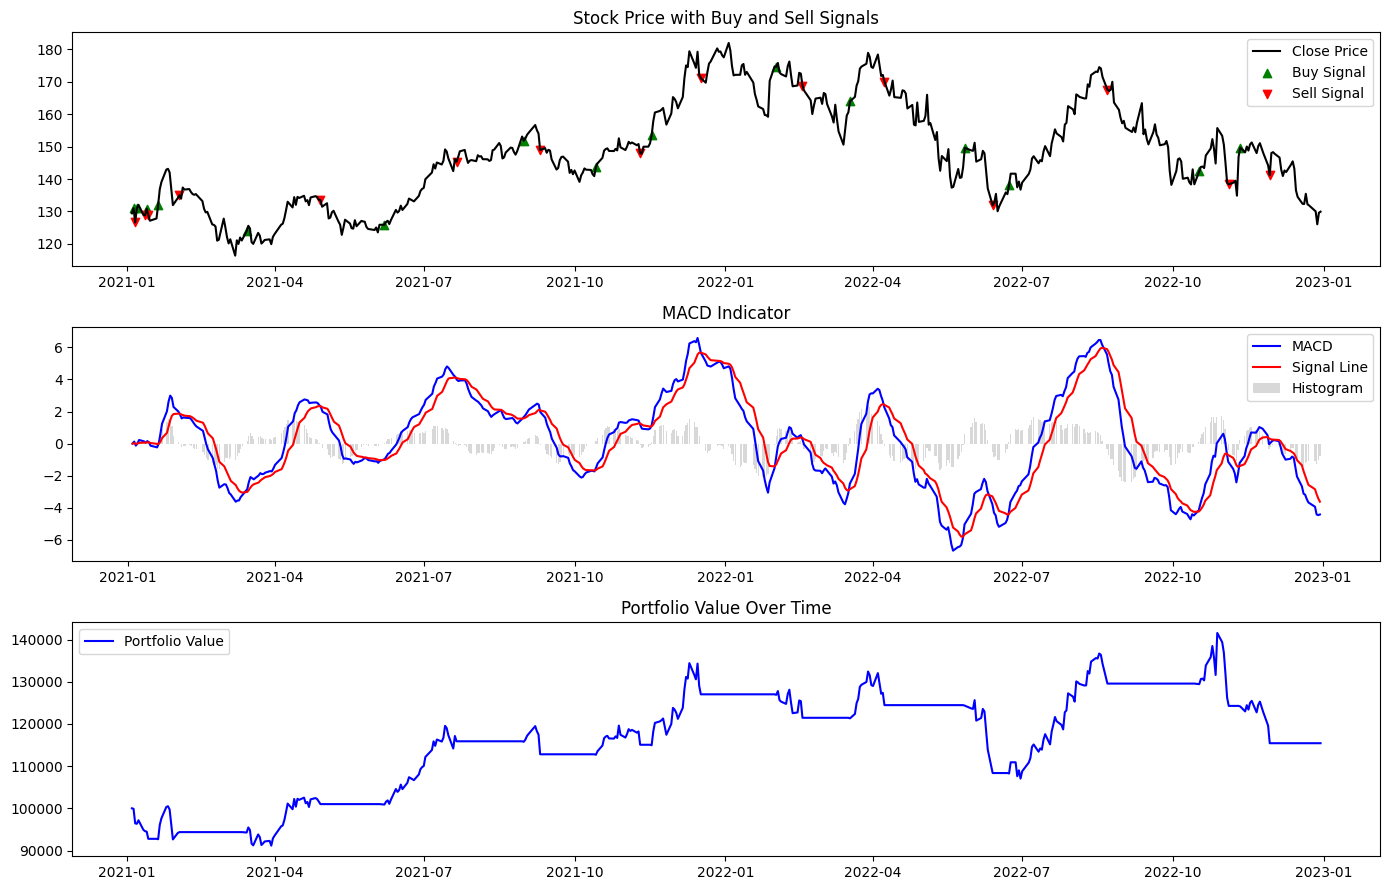

Initial Capital: 100000

Final Portfolio Value: 115435.5234973706

Net Profit/Loss: 15435.523497370596

Total Return (%): 15.435523497370596

Total Shares Bought: 11609.95028423474

Total Shares Sold: 11609.95028423474

Buy Prices: [np.float64(131.00999450683594), np.float64(130.9199981689453), np.float64(130.88999938964844), np.float64(132.02999877929688), np.float64(123.98999786376953), np.float64(125.9000015258789), np.float64(151.8300018310547), np.float64(143.75999450683594), np.float64(153.49000549316406), np.float64(174.61000061035156), np.float64(163.97999572753906), np.float64(149.63999938964844), np.float64(138.27000427246094), np.float64(142.41000366210938), np.float64(149.6999969482422)]

Sell Prices: [np.float64(126.5999984741211), np.float64(128.8000030517578), np.float64(128.91000366210938), np.float64(134.99000549316406), np.float64(133.47999572753906), np.float64(145.39999389648438), np.float64(148.97000122070312), np.float64(147.9199981689453), np.float64(171.13999938

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['Histogram'] = data['MACD'] - data['Signal']
    return data

def generate_signals(data):
    data['Buy_Signal'] = ((data['MACD'] > data['Signal']) & (data['MACD'].shift(1) <= data['Signal'].shift(1))).astype(int)
    data['Sell_Signal'] = ((data['MACD'] < data['Signal']) & (data['MACD'].shift(1) >= data['Signal'].shift(1))).astype(int)
    return data

def backtest(data, initial_capital=100000, transaction_cost=0.001):
    capital = initial_capital
    position = 0
    cash = capital
    portfolio_value = []
    bought_shares = 0
    sold_shares = 0
    buy_prices = []
    sell_prices = []

    for i in range(len(data)):
        if data['Buy_Signal'].iloc[i] == 1 and cash > 0:
            # Buy as much as possible
            shares_bought = cash / data['Close'].iloc[i]
            position += shares_bought
            bought_shares += shares_bought
            buy_prices.append(data['Close'].iloc[i])
            cash = 0
            # Subtract transaction cost
            cash -= transaction_cost * (shares_bought * data['Close'].iloc[i])
        elif data['Sell_Signal'].iloc[i] == 1 and position > 0:
            # Sell all position
            cash += position * data['Close'].iloc[i]
            sold_shares += position
            sell_prices.append(data['Close'].iloc[i])
            position = 0
            # Subtract transaction cost
            cash -= transaction_cost * (sold_shares * data['Close'].iloc[i])
        # Calculate portfolio value
        portfolio_value.append(cash + position * data['Close'].iloc[i])

    data['Portfolio_Value'] = portfolio_value

    # Calculate net profit/loss and return
    net_profit_loss = cash + position * data['Close'].iloc[-1] - initial_capital
    total_return = (net_profit_loss / initial_capital) * 100

    # Calculate risk-adjusted metrics
    returns = pd.Series(portfolio_value).pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    sortino_ratio = returns.mean() / returns[returns < 0].std() * np.sqrt(252)
    max_drawdown = (pd.Series(portfolio_value).cummax() - pd.Series(portfolio_value)).max()
    calmar_ratio = returns.mean() * 252 / max_drawdown

    # Metrics dictionary
    metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': portfolio_value[-1],
        'Net Profit/Loss': net_profit_loss,
        'Total Return (%)': total_return,
        'Total Shares Bought': bought_shares,
        'Total Shares Sold': sold_shares,
        'Buy Prices': buy_prices,
        'Sell Prices': sell_prices,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

    return data, metrics

def plot_macd(data):
    plt.figure(figsize=(14,9))

    # Plotting the stock price with buy and sell signals
    plt.subplot(3, 1, 1)
    plt.plot(data['Close'], label='Close Price', color='black')
    plt.scatter(data.index[data['Buy_Signal'] == 1], data['Close'][data['Buy_Signal'] == 1], color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(data.index[data['Sell_Signal'] == 1], data['Close'][data['Sell_Signal'] == 1], color='red', label='Sell Signal', marker='v', alpha=1)
    plt.title('Stock Price with Buy and Sell Signals')
    plt.legend()

    # Plotting the MACD indicator
    plt.subplot(3, 1, 2)
    plt.plot(data['MACD'], label='MACD', color='blue')
    plt.plot(data['Signal'], label='Signal Line', color='red')
    plt.bar(data.index, data['Histogram'], label='Histogram', color='grey', alpha=0.3)
    plt.title('MACD Indicator')
    plt.legend()

    # Plotting the portfolio value
    plt.subplot(3, 1, 3)
    plt.plot(data['Portfolio_Value'], label='Portfolio Value', color='blue')
    plt.title('Portfolio Value Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Fetch data
ticker = 'AAPL'  # Example ticker symbol
data = yf.download(ticker, start='2021-01-01', end='2023-01-01')

# Calculate MACD
data = calculate_macd(data)

# Generate buy and sell signals
data = generate_signals(data)

# Backtest the strategy
data, metrics = backtest(data)

# Plot the results
plot_macd(data)

# Print metrics
for key, value in metrics.items():
    print(f"{key}: {value}")
    print()